### Pathfinding of flying drones using rapidly exploring random tree (RRT) algorithm

In this notebook, we will use the rapidly-exploring random tree (RRT) algorithm to find a suitable flight trajectory for a drone. RRT is a motion planning algorithm that creates a tree of possible paths by randomly sampling points in space and connecting these points to the nearest branch in the tree. RRT* is an extension of RRT that uses cost-based optimization to improve the quality of the path. Informed RRT* is another extension that uses an informed sampling strategy to bias the sampling towards areas of the space that are more likely to contain a valid solution.

We will showcase how RRT can be implemented to find a path for a drone in a simulated environment. We will compare the performance of different variations of RRT, including the standard RRT, RRT*, and informed RRT*. We will progressively increase the complexity of the scenarios to test the capabilities of each RRT algorithm. 

In [1]:
# Imports
import numpy as np
import gym
import ipywidgets
from matplotlib import pyplot as plt

from controller.Quadrotor import Quadrotor
from controller.linear_controller import LinearPDController
from controller.nonlinear_controller import NonLinearPDController
from controller.trajectory import CustomTrajectory, CircleTrajectory, DiamondTrajectory, TUDTrajectory, HoverTrajectory

from RRT_planning.rrt_tools import GridMap, Configuration
from RRT_planning.RRT_algorithms.graphrrt import RRTPlanner
from RRT_planning.RRT_algorithms.informed_rrt_star import RRTPlanner as RRTStarPlanner

%matplotlib widget 

In [2]:
# Choose parameters

freq = 100 
simulation_time = 100

controller_name = "nonlinear" # ["nonlinear", "linear"] 
controller = NonLinearPDController()
#controller = LinearPDController()

dt = 1/freq
env = gym.make('Quadrotor-v0', disable_env_checker=True) # disable_env_checker to supress setup warnings

c:\Users\niels\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


#### RRT path planning with obstacles

In [3]:
# Set environment
grid = GridMap(100,100,100)

environment = 4

# 3 spheres on the path
if(environment == 1):
    grid.addObstacles(25,25,25, radius=10)
    grid.addObstacles(70,70,70, radius=10)
    grid.addObstacles(50,50,50, radius=10)

# Wall in center
if(environment == 2):
    grid.addRectangle(40, 40, 40, 6, 60, 80)

# Pillar in center
if(environment == 3):
    grid.addRectangle(40, 40, 40, 30, 30, 80)

# Maze
if(environment == 4):
    grid.addRectangle(20, 30, 40, 2, 60, 100)
    grid.addRectangle(20, 90, 40, 2, 20, 100)

    grid.addRectangle(40, 10, 40, 2, 20, 100)
    grid.addRectangle(40, 70, 40, 2, 60, 100)

    grid.addRectangle(60, 30, 40, 2, 60, 100)
    grid.addRectangle(60, 90, 40, 2, 20, 100)



Using RRT Star
Initialized RRT Planner with
startErrorMargin 75
goalErrorMargin 75
maxTimeTaken 10
maxNodesExpanded 10000
Number of nodes expanded 3175 and time taken 10.003870725631714
Found trajectory!
Total battery spent finishing task : 423680.64438610064


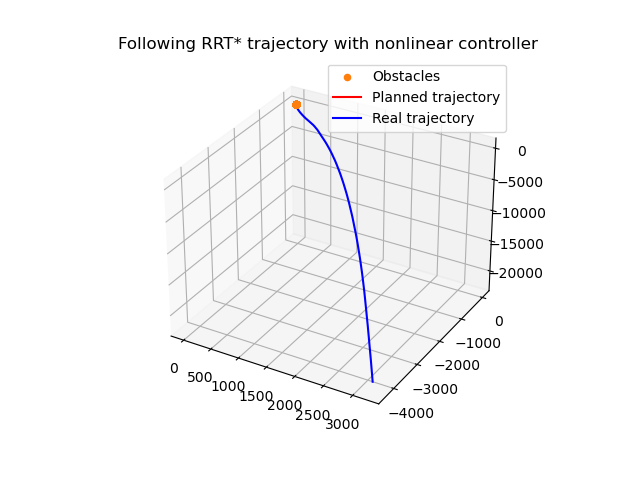

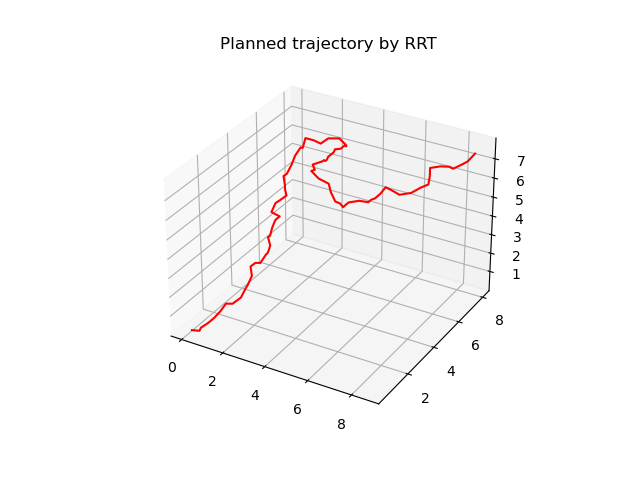

In [29]:
resolution = 0.1
connectorLength = 5
plannerName = "RRT*"
if plannerName == "RRT*":
    print("Using RRT Star")
    planner = RRTStarPlanner(grid, connectorLength=connectorLength, maxTimeTaken=10)
elif plannerName == "RRT":
    print("Using Vanilla RRT")
    planner = RRTPlanner(grid, connectorLength=connectorLength, maxTimeTaken=10)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y, z = grid.getMap().nonzero()
x = x * resolution
y = y * resolution
z = z * resolution
ax.scatter(x,y,z, 'g', c='#ff7f0e')
# ax.voxels(grid.getMap(), facecolors=[1,0,0,1])


# zz = np.zeros(pix_res) # set array with zeros first
# im1 = ax.imshow(zz,vmin=15,vmax=40) # plot image, with temperature bounds
# ax.draw_artist(im1) # draw image again
# fig.canvas.blit(ax.bbox) # blitting - for speeding up run
# fig.canvas.flush_events() # for real-time plot
startConfig = Configuration(0,0,0)
goalConfig = Configuration(80,80,80, np.pi)
traj = planner.getTrajectory(startConfig, goalConfig)
# traj = planner.getTrajectory(startConfig, goalConfig, ax=ax)
resolution = 0.1

def feedRRTTrajectory(trajectory : CustomTrajectory):
    t = 0
    start_pos = trajectory.getDesState(t)['x']
    end_pos = trajectory.getDesState(simulation_time)['x']
    cur_state = env.reset(position=start_pos)

    plan_trajectory = {'x' : [], 'y' : [], 'z' : []}
    real_trajectory = {'x' : [], 'y' : [], 'z' : []}
    w_history = []
    while t < simulation_time:
        des_state = trajectory.getDesState(t)
        ctrl_var = controller.control(des_state, cur_state)
        action = ctrl_var['cmd_motor_speeds']
        cur_state, reward, done, info = env.step(action)

        plan_trajectory['x'].append(des_state['x'][0])
        plan_trajectory['y'].append(des_state['x'][1])
        plan_trajectory['z'].append(des_state['x'][2])

        cur_x = cur_state['x'][0]
        cur_y = cur_state['x'][1]
        cur_z = cur_state['x'][2]

        real_trajectory['x'].append(cur_x)
        real_trajectory['y'].append(cur_y)
        real_trajectory['z'].append(cur_z)
        
        w_history.append(cur_state['w'])

        t += dt
    return plan_trajectory, real_trajectory, w_history

if traj != []:
    print("Found trajectory!")
    list_traj = [(point.pos.x * resolution, point.pos.y * resolution, point.pos.z * resolution ) for point in traj]
    trajWithProfile = CustomTrajectory(dt, list_traj, T=100, name=plannerName)
    plan_trajectory, real_trajectory, w_history = feedRRTTrajectory(trajWithProfile)
    print(f"Total battery spent finishing task : {sum(sum(w**2) for w in w_history)}" )
    ax.set_title(f"Following {trajWithProfile.getName()} trajectory with {controller_name} controller")
    ax.plot(plan_trajectory['x'], plan_trajectory['y'], plan_trajectory['z'], c='#FF0000')
    ax.plot(real_trajectory['x'], real_trajectory['y'], real_trajectory['z'], c='#0000FF')
    ax.legend(["Obstacles", "Planned trajectory", "Real trajectory"])
else:
    print("Failed finding trajectory")

# Plot of planned trajectory
fig= plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Planned trajectory by RRT")
if ax is not None:
    y = np.array([point.pos.y * resolution for point in traj])
    x = np.array([point.pos.x * resolution for point in traj])
    z = np.array([point.pos.z * resolution for point in traj])
    ax.plot(x, y, z, '-r')

### Following trajectory with controller

Adapted from the Dynamics & Control practicum code.

##### Choose Parameters:

In [5]:
# freq = 100 
# simulation_time = 60

# dt = 1/freq
# env = gym.make('Quadrotor-v0', disable_env_checker=True) # disable_env_checker to supress setup warnings
t = 0

# controller_name = "nonlinear" # ["nonlinear", "linear"] 
# controller = NonLinearPDController()
# # controller = LinearPDController()

trajectory_name = "circle" # ["circle", "diamond", "TUD", "HOVER"]
trajectory = CircleTrajectory(dt, radius=5, end_z=2.5, T=9)
# trajectory = DiamondTrajectory(dt, end_x=1, T=7)
# trajectory = TUDTrajectory(dt)
# HoverTrajectory(dt, hoverHeight=5, T=5)


##### Calculate and plot trajectory

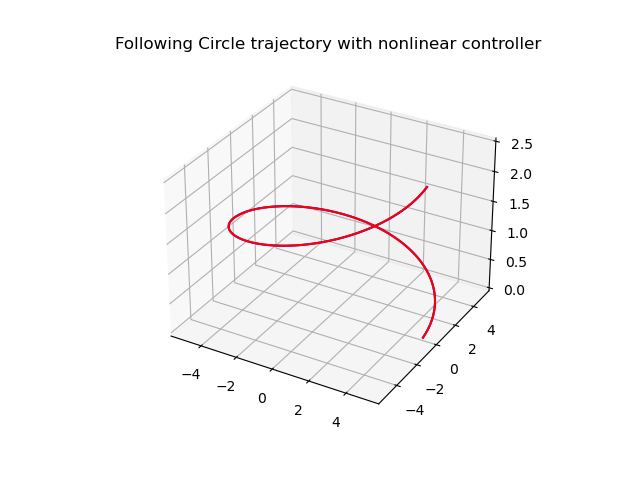

In [6]:
start_pos = trajectory.getDesState(t)['x']
end_pos = trajectory.getDesState(simulation_time)['x']
cur_state = env.reset(position=start_pos)

plan_trajectory = {'x' : [], 'y' : [], 'z' : []}
real_trajectory = {'x' : [], 'y' : [], 'z' : []}

while t < simulation_time:
    des_state = trajectory.getDesState(t)
    ctrl_var = controller.control(des_state, cur_state)
    action = ctrl_var['cmd_motor_speeds']
    cur_state, reward, done, info = env.step(action)

    plan_trajectory['x'].append(des_state['x'][0])
    plan_trajectory['y'].append(des_state['x'][1])
    plan_trajectory['z'].append(des_state['x'][2])

    cur_x = cur_state['x'][0]
    cur_y = cur_state['x'][1]
    cur_z = cur_state['x'][2]

    real_trajectory['x'].append(cur_x)
    real_trajectory['y'].append(cur_y)
    real_trajectory['z'].append(cur_z)

    t += dt

fig_dc = plt.figure()
ax_dc = fig_dc.add_subplot(projection='3d')
ax_dc.set_title(f"Following {trajectory.getName()} trajectory with {controller_name} controller")
ax_dc.plot(plan_trajectory['x'], plan_trajectory['y'], plan_trajectory['z'], c='#0000FF')
ax_dc.plot(real_trajectory['x'], real_trajectory['y'], real_trajectory['z'], c='#FF0000')
plt.show()